


**Install and import dependencies**




In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
# Import tensorFlow and Tensorflow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

tf.enable_eager_execution()  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


** Import the Fashion MNIST dataset**

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print(num_train_examples)
print(num_test_examples)

60000
10000


** Preprocess the data **

The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.


In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

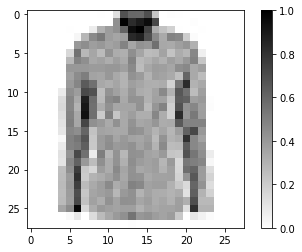

In [8]:
for image, label in test_dataset.take(1):
  break

image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

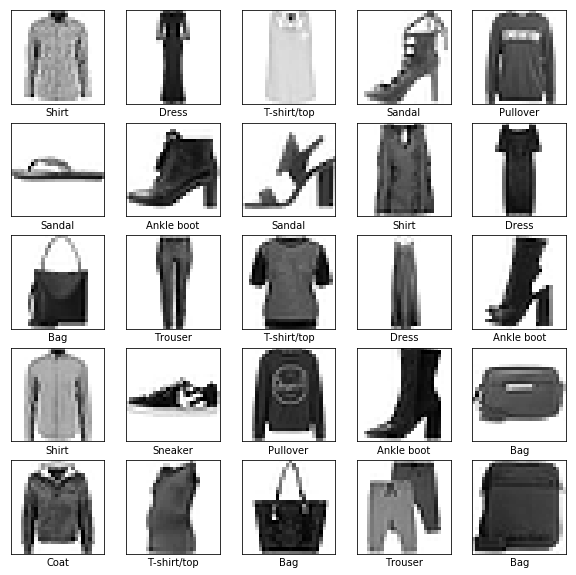

In [9]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

** Build the Model **

** Setup the layers **

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network has three layers:

    input tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28 × 28 pixels, to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

    "hidden" tf.keras.layers.Dense— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

    output tf.keras.layers.Dense — A 10-node softmax layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

    Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
    Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
    Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

** Train the Model **

First, we define the iteration behavior for the train dataset:

   * Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
   
   * The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
   
   * And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the model.fit method:

   * Feed the training data to the model using train_dataset.
   * The model learns to associate images and labels.
   * The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.


In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4948 - acc: 0.8266
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3738 - acc: 0.8671
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3356 - acc: 0.8782
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3072 - acc: 0.8875
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2933 - acc: 0.8919


** Evaluate accuracy **

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3347 - acc: 0.8799
Accuracy on test dataset: 0.8799


** Make Predictions **

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [16]:
predictions.shape

(32, 10)

In [17]:
predictions[0]

array([1.0925361e-05, 3.1879517e-09, 3.2062156e-03, 4.0365416e-05,
       5.6919888e-02, 3.8210717e-07, 9.3982106e-01, 8.8232699e-11,
       1.1605960e-06, 7.7048434e-10], dtype=float32)

In [18]:
np.argmax(predictions[0])

6

In [19]:
test_labels[0]

6

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

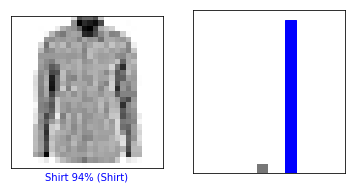

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

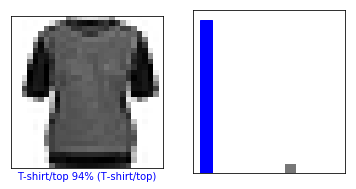

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

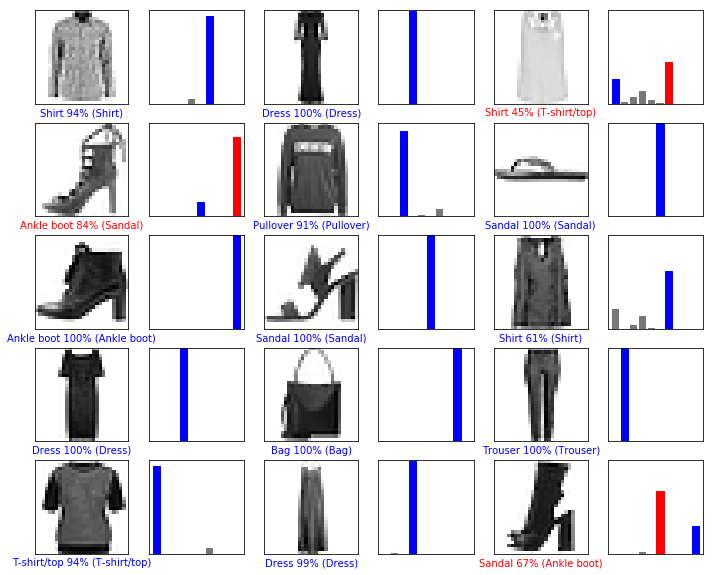

In [23]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [24]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [25]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [26]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.0925359e-05 3.1879575e-09 3.2062165e-03 4.0365412e-05 5.6919936e-02
  3.8210752e-07 9.3982095e-01 8.8232685e-11 1.1605979e-06 7.7048568e-10]]


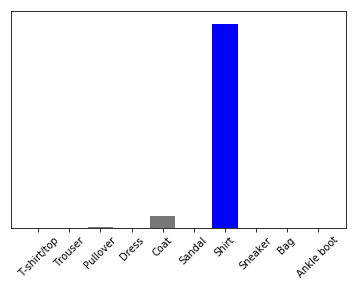

In [27]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [28]:
np.argmax(predictions_single[0])

6